In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             roc_auc_score)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.utils import resample

warnings.filterwarnings('ignore')

In [2]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

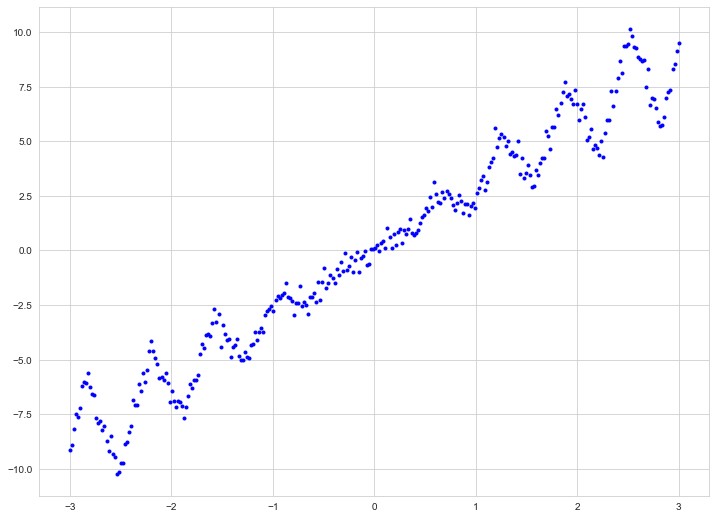

In [4]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [5]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$", color='cyan')

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

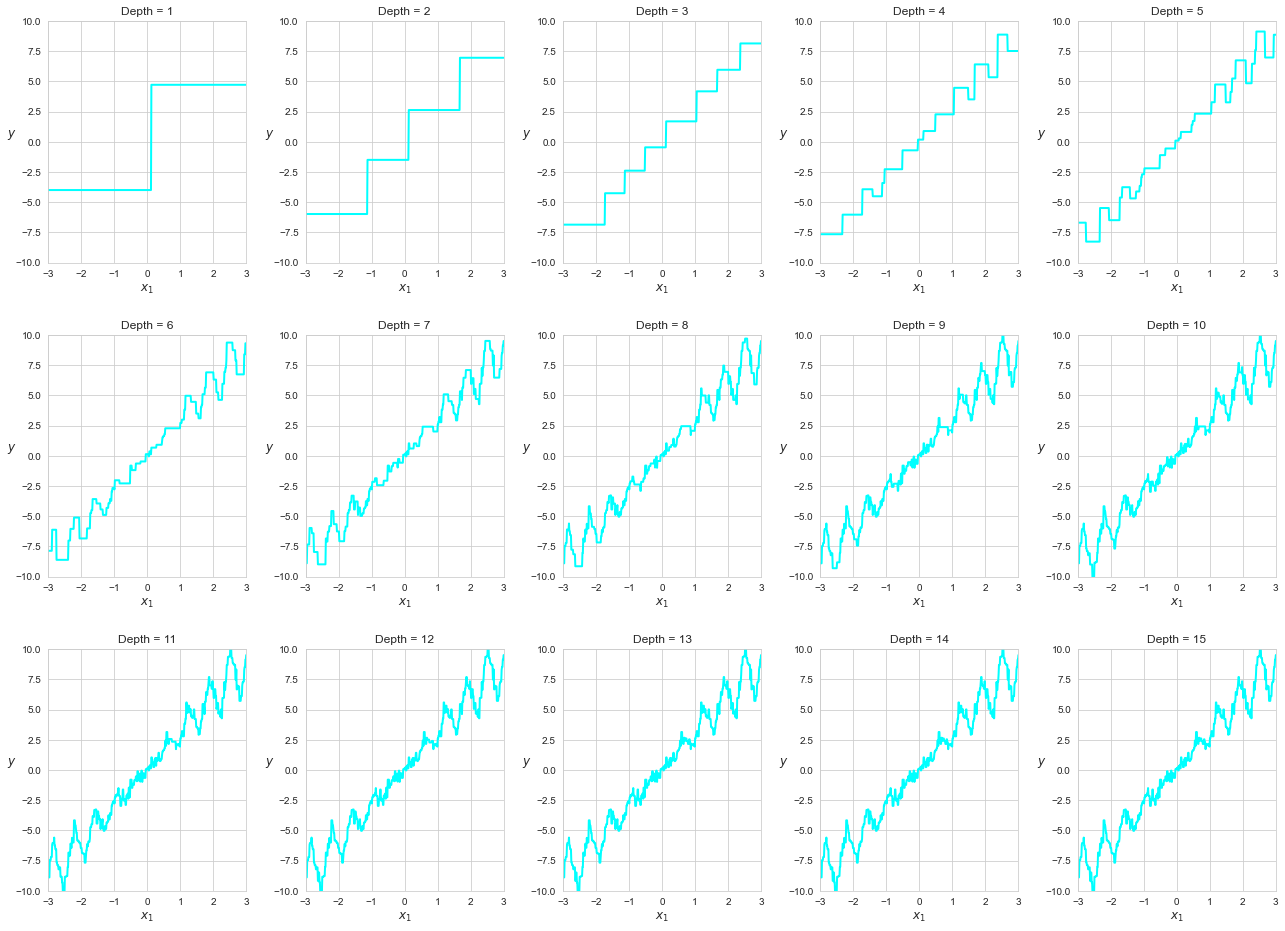

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(22, 16))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

for depth in range(1, 16):
    tree_reg = DecisionTreeRegressor(random_state=SEED, max_depth=depth).fit(X_train, y_train)
    ax1 = plt.subplot(3, 5, depth)
    plot_regression_predictions(tree_reg, X, y)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax1.set_title(f'Depth = {depth}', fontsize=12)

В целом, глубины от 7 начинают становиться очень похожими друг на друга, точки предсказывают при этом хорошо

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

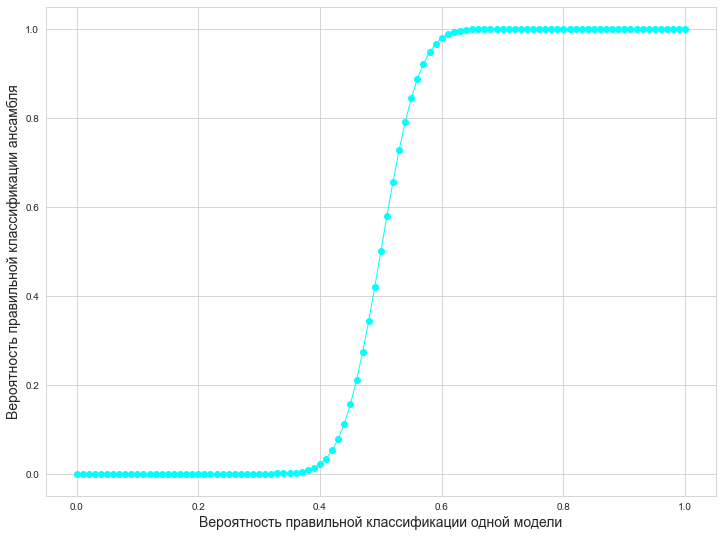

In [7]:
individual = np.arange(0.0, 1.01, 0.01)
ensemble = []
for p in individual:
    probabil = np.sum([math.factorial(101) / ((math.factorial(101 - i) * math.factorial(i))) * p ** i * (1 - p) ** (101 - i) for i in range(51, 102)])
    ensemble.append(probabil)
    
df = pd.DataFrame(data={'individual': individual, 'ensemble': ensemble})

plt.plot(df.individual, df.ensemble, 'o-', linewidth=1, color='cyan')
plt.xlabel('Вероятность правильной классификации одной модели', fontsize=14)
plt.ylabel('Вероятность правильной классификации ансамбля', fontsize=14);

In [8]:
df[df.individual >= 0.70]

,individual,ensemble
70,0.70,0.999987
71,0.71,0.999995
72,0.72,0.999999
73,0.73,1.000000
74,0.74,1.000000
75,0.75,1.000000
76,0.76,1.000000
77,0.77,1.000000
78,0.78,1.000000
79,0.79,1.000000


А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

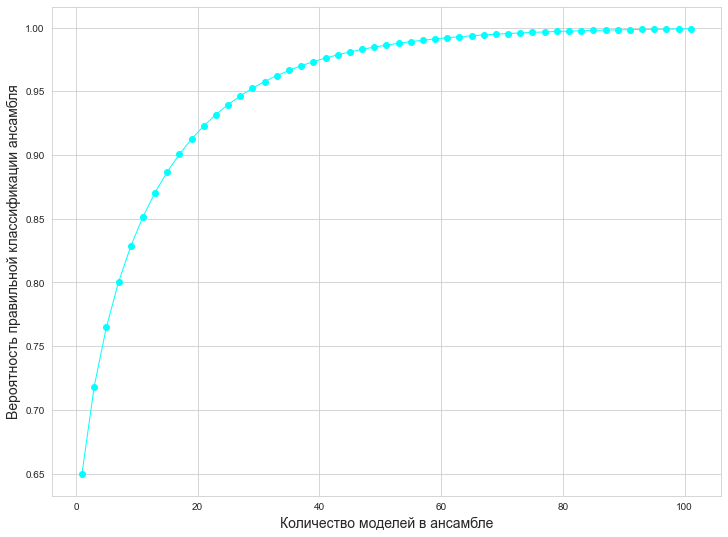

In [9]:
individual = 0.65
models = np.arange(1, 102, 2)
ensemble = []

for i in models:
    votes = i // 2 + 1
    probabil = np.sum([math.factorial(i) / ((math.factorial(i - vote) * math.factorial(vote))) * individual ** vote * 0.35 ** (i - vote) for vote in range(votes, i + 1)])
    ensemble.append(probabil)
    
df = pd.DataFrame(data={'models': models, 'ensemble': ensemble})
plt.plot(df.models, df.ensemble, 'o-', linewidth=1, color='cyan')
plt.xlabel('Количество моделей в ансамбле', fontsize=14)
plt.ylabel('Вероятность правильной классификации ансамбля', fontsize=14);

Опишите ваши наблюдения:

* При построении графика зависимости вероятности правильно классифицировать объект от вероятности, равной для всех моделей, у нас получается сигмоидальный графк. Можно отметить что, начиная с р = 0.5 (примерно) эффективность предсказывания ансамбля возрастает. К р = 0.73 вероятность правильной классификации приходит к 1, хотя уже при р = 0.63 вероятность правильной классификации правктически равна единицу (0.992935, если быть точным). Итак, при классификации ансамблем модели исправляют ошибки друг друга, в итоге у нас имеется лучший результат.
* Когда у нас фиксирована вероятность каждой модели на 0.65, график вероятности верной классификации ими в ансамбле с разным количеством моделей похоже на экспоненциальный график. Чем больше моделей объединяются в ансамбль, тем выше вероятность верной классификации. При 65-70 моделей ансамбль вполне успешно справляется с задачей. Итак, несколько независимых классификаторов лучше, чем один.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [10]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feature_ids = np.random.choice(range(X.shape[1]), self.max_features, replace=False)
            samples = np.unique(np.random.choice(range(X.shape[0]), X.shape[0], replace=True))
            self.feat_ids_by_tree.append(feature_ids)
            
            ps_X = X[samples][:, feature_ids]
            ps_y = y[samples]
            
            tree = DecisionTreeClassifier(max_depth=self.max_depth, 
                                        max_features=self.max_features, 
                                        random_state = self.random_state)

            tree.fit(ps_X, ps_y)
            self.trees.append(tree)
        return self

    def predict_proba(self, X):
        y_pred = np.zeros((X.shape[0], len(self.classes_)))
        for tree, feat_ids in zip(self.trees, self.feat_ids_by_tree):
            y_pred += tree.predict_proba(X[:, feat_ids])
        return y_pred
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [11]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

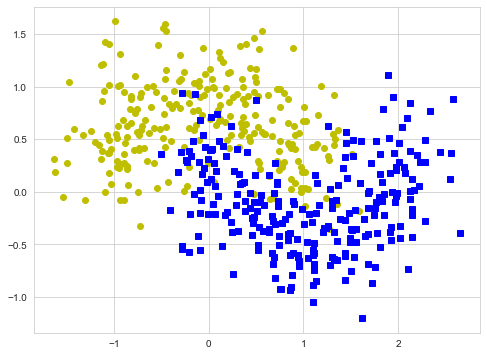

In [12]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1,
                                                    random_state=SEED)

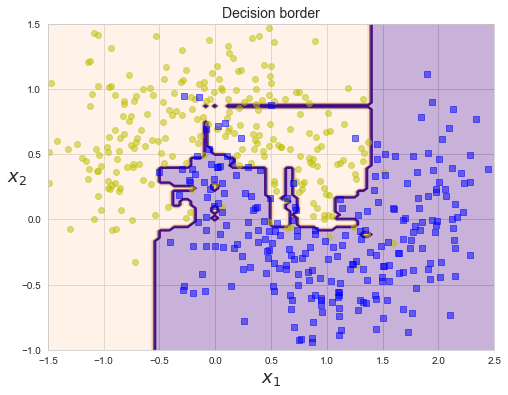

In [14]:
plt.figure(figsize=(8, 6))
tree = RandomForestClassifierCustom(n_estimators=18, max_depth=10, max_features=2, random_state=SEED)
tree.fit(X_train, y_train)
plot_decision_boundary(tree, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

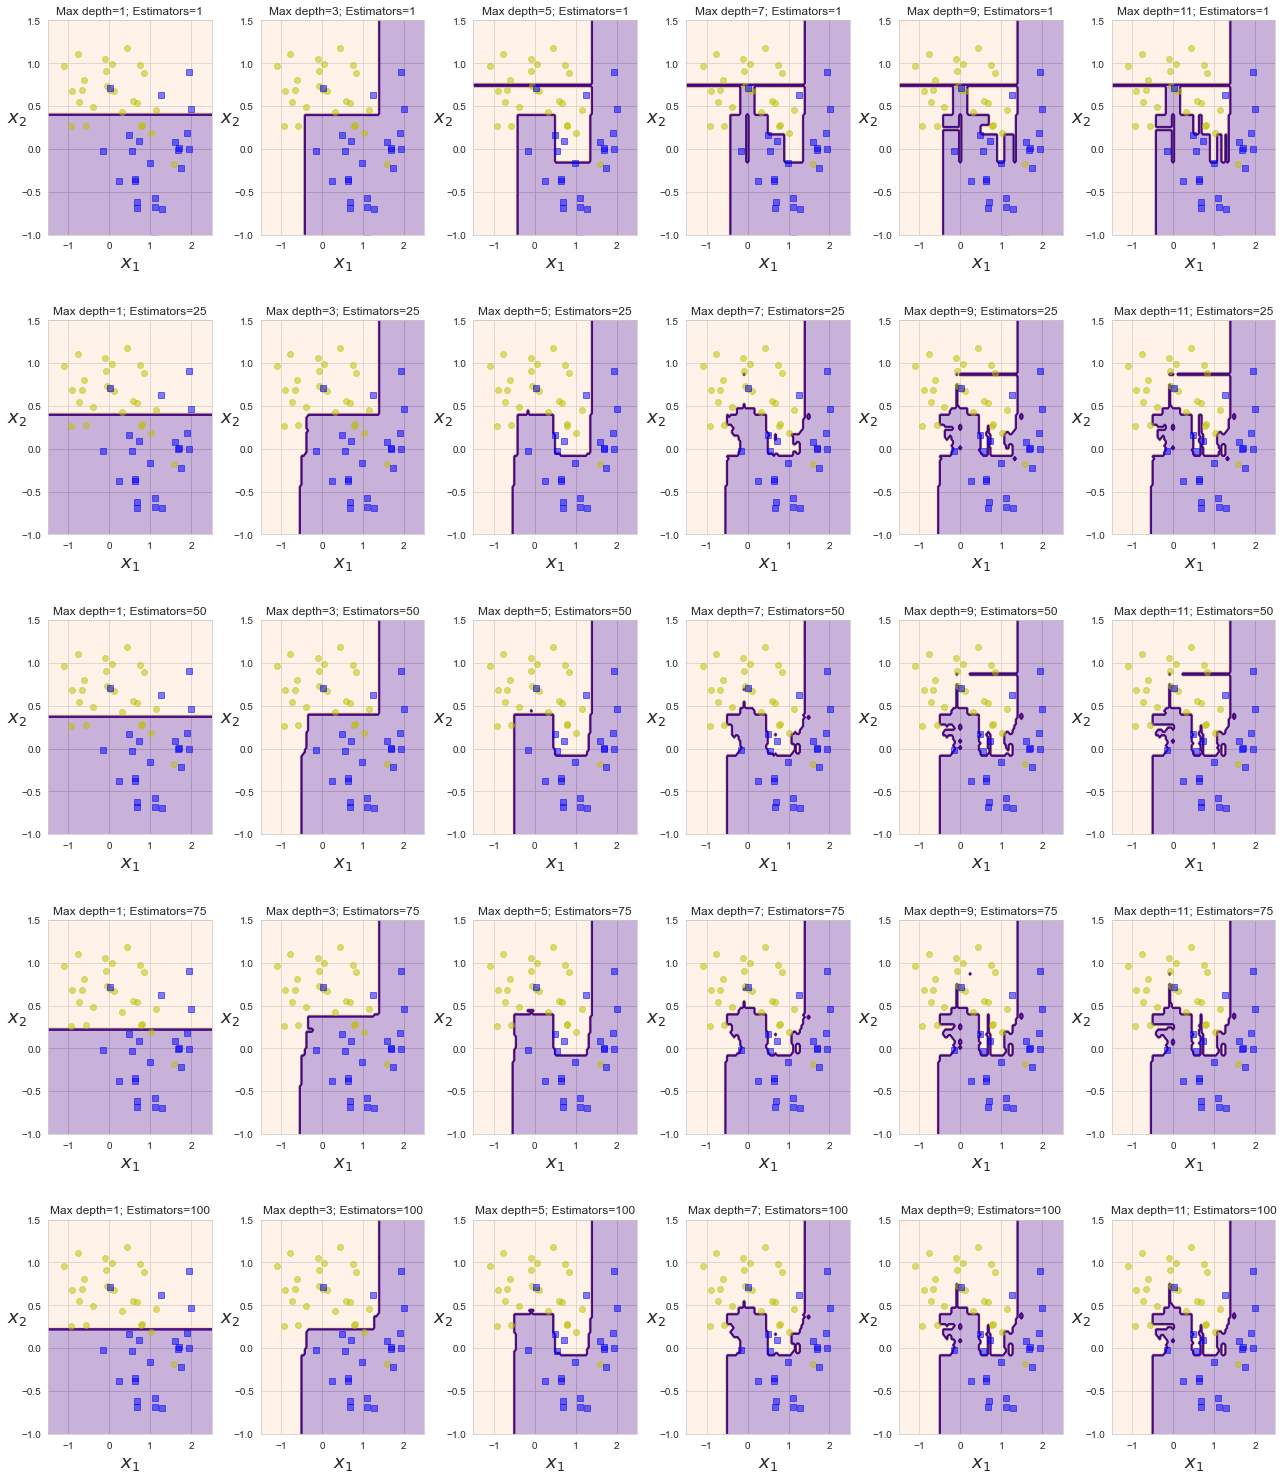

In [15]:
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(22, 26))
count = 1
for estimators in [1, 25, 50, 75, 100]: #[1, 25, 50, 75, 100]
    for depth in [1, 3, 5, 7, 9, 11]:
        tree = RandomForestClassifierCustom(n_estimators=estimators,
                                            max_depth=depth,
                                            max_features=2)
        tree.fit(X_train, y_train)
        tree.predict_proba(X_train)
        ax1 = plt.subplot(5, 6, count)
        plot_decision_boundary(tree, X_test, y_test)
        ax1.set_title(f'Max depth={depth}; Estimators={estimators}')
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        count+= 1

Как мне кажется, наилучшая разделяющая граница у max_deph=7, Estimators = 50/75/100. Возьмем Estimators = 100 и построим график

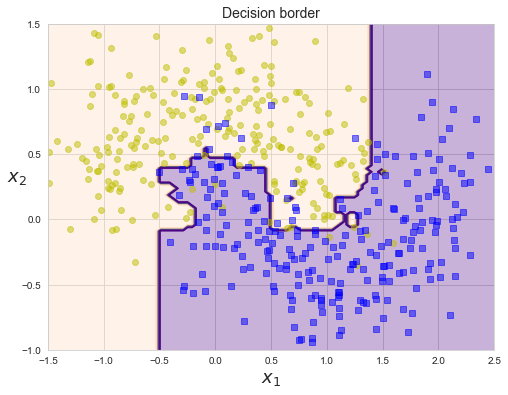

In [16]:
plt.figure(figsize=(8, 6))
tree = RandomForestClassifierCustom(n_estimators=100, max_depth=7, max_features=2, random_state=SEED)
tree.fit(X_train, y_train)
plot_decision_boundary(tree, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Красота

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [17]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [18]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
result = []
for max_feat in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]:
    forest = RandomForestClassifier(max_features=max_feat)
    fit_forest = forest.fit(X_train, y_train)
    corr_pairs = base_model_pair_correlation(fit_forest, X_test)
    result.append(corr_pairs)

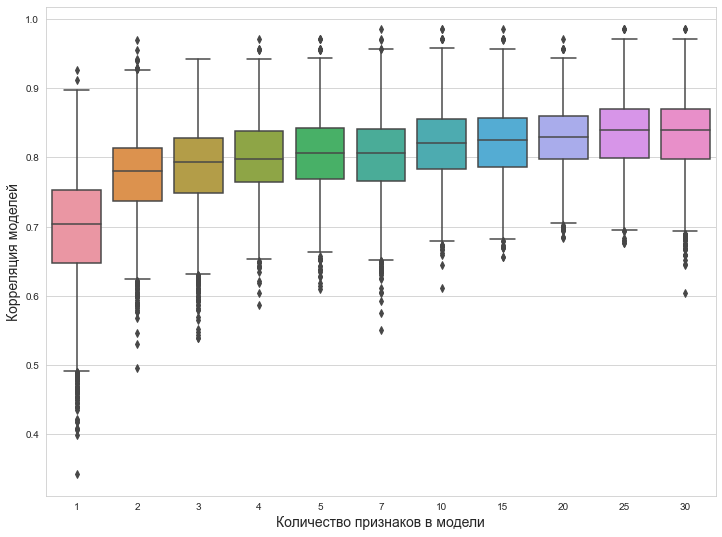

In [20]:
df = pd.DataFrame(np.array(result).T, columns=[1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30])
ax = sns.boxplot(data=df)
plt.xlabel('Количество признаков в модели', fontsize=14)
plt.ylabel('Корреляция моделей', fontsize=14);

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [21]:
result = []
for depth in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]:
    forest = RandomForestClassifier(max_depth=depth)
    fit_forest = forest.fit(X_train, y_train)
    corr_pairs = base_model_pair_correlation(fit_forest, X_test)
    result.append(corr_pairs)

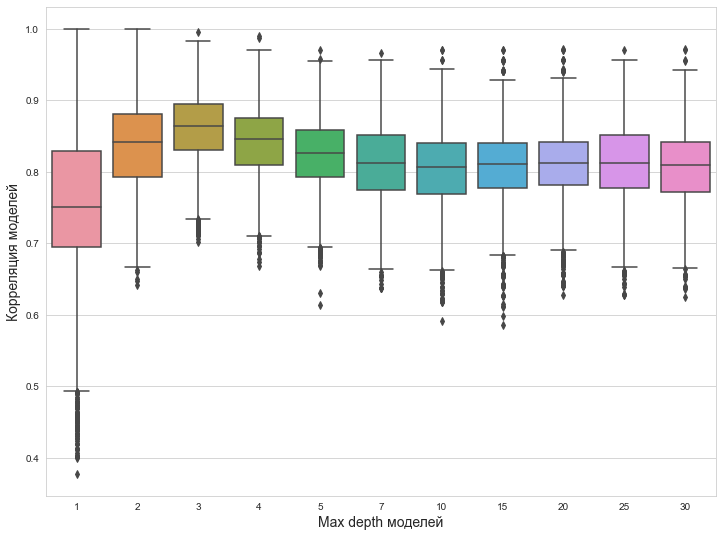

In [22]:
df = pd.DataFrame(np.array(result).T, columns=[1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30])
ax = sns.boxplot(data=df)
plt.xlabel('Max depth моделей', fontsize=14)
plt.ylabel('Корреляция моделей', fontsize=14);

Опишите ваши наблюдения:

* При увеличении числа признаков корреляция растет. До значения параметра max_features = 5 происходит рост корреляции, далее корреляцию вызходит на более-менее плато (около 0.80-0.90).
* При max_depth=1 корреляция наибольшая (но также график растянут - сложно предсказать повеление модели), далее корреляция моделей незначительно убывает и выходит на плато в районе 0.80-0.85 при увеличении глубины около 7-10. В случайном лесе используются глубокие деревья.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [23]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [24]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [25]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(verbose=-1, random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(verbose=-1, boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(verbose=-1,random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

Мне в безумном количестве падало

`[LightGBM] [Warning] No further splits with positive gain, best gain: -inf` 


Это исправлялось добавлением verbose=-1, так что я это сделала

In [26]:
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_hard = VotingClassifier(estimators=base_models, voting='hard')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8463991769547325
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8445754787218203
VotingClassifier: 0.8503633581946834


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [27]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [28]:
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  RandomForestClassifier(n_estimators=50, random_state=111),
  0.8134894007824363),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  ExtraTreesClassifier(random_state=111),
  0.7749544834941163),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  KNeighborsClassifier(weights='distance'),
  0.3133294966283544),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(kernel='linear', probability=True, random_state=111),
  0.715376472596946),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(probability=True, random_state=111),
  0.28201353566953785),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  0.7875690140798687),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(random_state=111, verbose=-1),
  0.8282760

In [29]:
def get_score(estimators, voting_type='soft'):
    voting = VotingClassifier(estimators=estimators, voting=voting_type)
    voting.fit(X_train, y_train)
    return cross_val_score(voting, X_train, y_train, cv=3, scoring="f1")
    
    
get_score(base_models, voting_type='soft').mean()

0.8503633581946834

Супер, как будто неплохо работает

А теперь чтобы не перебирать вручную реализуем небольшой код, чтобы сделать прогон всех заданных комбинаций и получить cross_val_score и помолимся чтобы комп не отключился

Ниже ячейка кода для перебора комбинаций, записывает score и сами модели в ансамбле. Сначала я пыталась логикой подобрать, но в итоге решила чтобы компьютор повычислял за меня.



Код работает примерно вечность (13 часов кажется, надо было поточнее засечь), a еще он выводит очень длинное полотно, потому что я хотела смотреть что он что-то делает. 


В общем чтобы не пришлось ОЧЕНЬ много проматывать (по длине вывод был практически как вся моя работа), я переделаю программу чтобы она выводила только один пример - просто как пример работы и заккоментирую, а прошлый результат будет сохранен в `models_cross_val_score.csv`.

In [30]:
import itertools
n_models = len(base_models)
best_scores = []
comb_models = []
possible_comb = itertools.combinations(base_models, n_models)

while n_models > 1:
    for comb in possible_comb:
        score = get_score(list(comb))
        if any([x > 0.86 for x in score]):
            tmp = []
            best_scores.append(score)
            for model_info in comb:
                tmp.append(str(model_info[1]).split('(')[0])
            comb_models.append(tmp)
            print(f'Models: {tmp},\n score = {score.mean()}')
            break
        else:
            continue
    n_models -= 1

Models: ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'KNeighborsClassifier', 'SVC', 'SVC', '<catboost.core.CatBoostClassifier object at 0x00000226847E41C0>', 'LGBMClassifier', 'LGBMClassifier', 'XGBClassifier', 'XGBRFClassifier', 'LogisticRegression', 'GaussianNB'],
 score = 0.8503633581946834


Дальше будет обработка полученных списков, я ее закомментирую, потому что запускать код на 10 часов - не прикол (да и я его изменила уже). Приложу датасет получившийся здесь в виде csv и ниже можно будет просто его прочесть.

In [31]:
#models_cross_val_score = pd.DataFrame(
#    {'models': comb_models,
#     'cross_val_score': best_scores
#    })
#models_cross_val_score

In [32]:
#models_cross_val_score.cross_val_score = models_cross_val_score.cross_val_score.apply(lambda x: x.mean())

In [33]:
#models_cross_val_score.to_csv('../data/models_cross_val_score.csv')
models_cross_val_score = pd.read_csv('../data/models_cross_val_score.csv', index_col=0)
models_cross_val_score

,models,cross_val_score
0,"['DecisionTreeClassifier', 'RandomForestClassi...",0.850363
1,"['DecisionTreeClassifier', 'RandomForestClassi...",0.853614
2,"['DecisionTreeClassifier', 'RandomForestClassi...",0.850363
3,"['DecisionTreeClassifier', 'RandomForestClassi...",0.845511
4,"['DecisionTreeClassifier', 'RandomForestClassi...",0.845104
...,...,...
8015,"['XGBClassifier', 'LogisticRegression']",0.849280
8016,"['XGBClassifier', 'GaussianNB']",0.836219
8017,"['XGBRFClassifier', 'LogisticRegression']",0.855459
8018,"['XGBRFClassifier', 'GaussianNB']",0.835075


In [34]:
max_prediction_score = max(models_cross_val_score['cross_val_score'])
max_preciction_models = models_cross_val_score[models_cross_val_score['cross_val_score'] == max_prediction_score]

print(f'Best score: {max_prediction_score}')
print(f'Models: {max_preciction_models.iloc[0]["models"]}')

Best score: 0.8706643151087595
Models: ['DecisionTreeClassifier', 'SVC', '<catboost.core.CatBoostClassifier object at 0x000002569B683D30>', 'LGBMClassifier', 'XGBRFClassifier', 'LogisticRegression', 'GaussianNB']


Еще раз посмотрим кросс-валидационный и f1 score для получившегося ансамбля:

In [35]:
base_models = [("DT", dt), ("SVC_LIN", svc_lin),
               ("CAT", cat), ("LGBM_RF", lgbm_rf), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

score = get_score(base_models)
print('cross val score', score.mean())

voting_soft = VotingClassifier(base_models, voting='soft')
voting_soft.fit(X_train, y_train)
print('f1 score: ', f1_score(y_test, voting_soft.predict(X_test)))

cross val score 0.8706643151087595
f1 score:  0.8737864077669905


Комбинация данных моделей дает наибольшее качество предсказания равное 0.8707. Выше результата, к сожалению, даже после всех страданий и усилий, не получилось. Даже просто перебор программой всех возможных комбинаций моделей не помог.


Я предполагаю что проблема может быть в том, что я добавила `verbose=-1` для двух LGBMClassifier:

`
lgbm = lightgbm.LGBMClassifier(verbose=-1, random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(verbose=-1, boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
`

 поскольку у меня вылезало предупреждение: `[LightGBM] [Warning] No further splits with positive gain, best gain: -inf`  

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [36]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


Возьму следующие модели:


* xgboost.XGBClassifier
* lightgbm.LGBMClassifier(boosting_type="rf")

Для начала поработаем с данными:

In [37]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [38]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Посмотрим, есть ли в данных дубликаты:

In [39]:
duplicate_rows = data[data.duplicated()]
print("Количество строк-дубликатов: ", duplicate_rows.shape[0])

Количество строк-дубликатов:  0


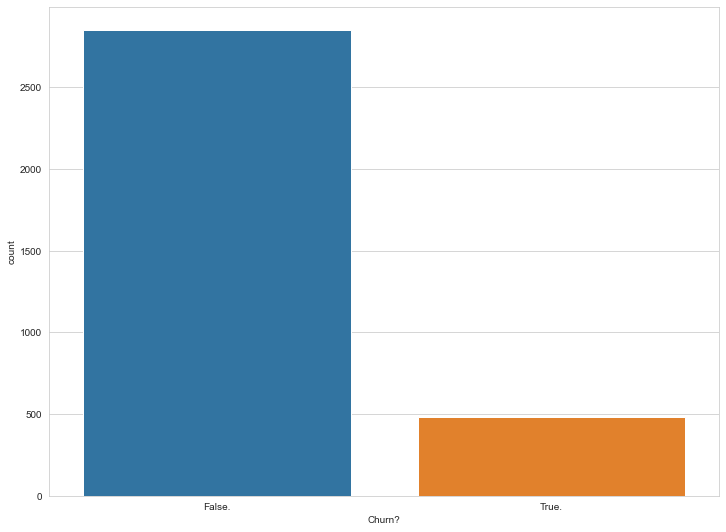

In [40]:
sns.countplot(data=data, x='Churn?')
plt.show()

Что ж будем что-то делать с дисбалансом классов.


Посмотрим, есть ли NA:

In [41]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

Теперь обратимся к колонкам `Int'l Plan`, `VMail Plan` и `Churn?`. Заменим no/yes и False./True. на 0/1.

И сразу переименуем колонку `Churn?`

In [42]:
data.replace({'True.': 1, 'False.': 0, 'yes': 1, 'no': 0}, inplace=True)

In [43]:
data = data.rename(columns={"Churn?":"Churn"})

In [44]:
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Проверим колонку Phone - вероятнее всего она уникальна для каждого значения. Еще хочется убрать колонки State и Area Code, они тоже кажутся ненужными

In [45]:
for i in ['Phone', 'State', 'Area Code']:
    print(f'Unique recordings in {i} column: {data[i].unique()}, number: {len(data[i].unique())}')

Unique recordings in Phone column: ['382-4657' '371-7191' '358-1921' ... '328-8230' '364-6381' '400-4344'], number: 3333
Unique recordings in State column: ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND'], number: 51
Unique recordings in Area Code column: [415 408 510], number: 3


Штатов много, кажется это довольно нужная информация, уберем только телефон.

In [46]:
data = data.drop("Phone", axis = 1)

Теперь посмотрим на корреляцию при помощи heatmap

<AxesSubplot:>

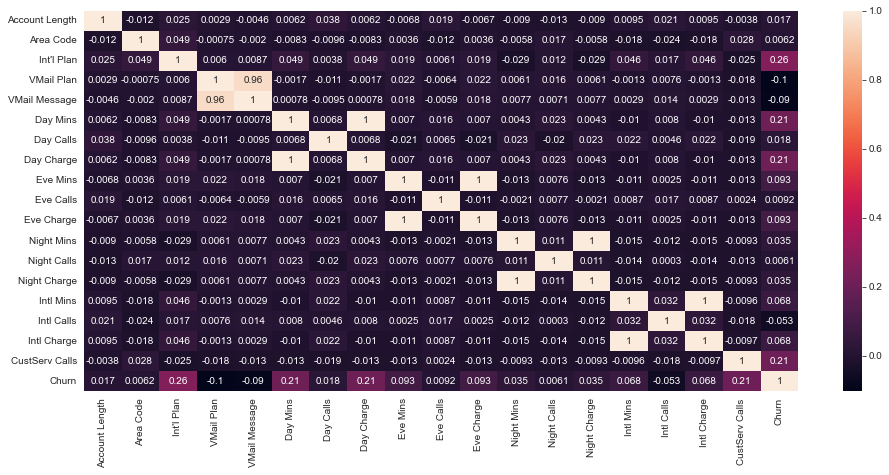

In [47]:
plt.figure(figsize=(16, 7))
sns.heatmap(data.corr(), annot = True)

Даже не ожидала столько коррелирующих между собой переменных. Уберем по одной из пар:

In [48]:
data.drop(['VMail Plan', 'Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins'], axis=1, inplace=True)
data.head()

,State,Account Length,Area Code,Int'l Plan,VMail Message,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,CustServ Calls,Churn
0,KS,128,415,0,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0
1,OH,107,415,0,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0
2,NJ,137,415,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0
3,OH,84,408,1,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0
4,OK,75,415,1,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0


Вернемся к дисбалансу классов:

In [49]:
data['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

In [50]:
data_0 = data[data['Churn'] == 0]
data_1 = data[data['Churn'] == 1]

Будем приводить все к 0 классу. То есть к 2850.

In [51]:
data_r_1 = resample(data_1, 
                    replace=True, 
                    n_samples=2850,
                    random_state=SEED)

r_data = pd.concat([data_r_1, data_0])

In [52]:
r_data.Churn.value_counts()

1    2850
0    2850
Name: Churn, dtype: int64

In [53]:
X = r_data.drop(['Churn'], axis=1)
y = r_data[['Churn']]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [55]:
X.head()

,State,Account Length,Area Code,Int'l Plan,VMail Message,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,CustServ Calls
2437,CA,105,415,0,31,108,18.63,119,21.19,101,14.45,4,2.24,4
2606,AR,145,415,0,0,89,38.11,121,26.77,121,8.23,3,4.35,1
3243,AR,113,415,1,0,112,20.77,94,11.19,106,7.63,9,2.78,5
1679,OK,82,510,0,0,73,56.07,120,17.71,102,12.02,6,2.86,0
613,NV,105,415,1,29,82,37.52,110,18.50,100,8.57,6,3.56,1


In [56]:
forest = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)

forest.fit(X_train._get_numeric_data(), y_train._get_numeric_data())
y_pred = forest.predict(X_test._get_numeric_data())
f1 = f1_score(y_test, y_pred)
accuracy = round(accuracy_score(y_test, y_pred), 3)
print(f'f1 score = {round(f1,4)}\naccuracy = {accuracy}')
print(f'ROC-AUC: {round(roc_auc_score(y_test, y_pred),4)}')

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 2299, number of negative: 2261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 4560, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0

In [57]:
boost = xgboost.XGBClassifier(n_estimators=500, random_state=SEED)

boost.fit(X_train._get_numeric_data(), y_train._get_numeric_data())
y_pred = boost.predict(X_test._get_numeric_data())
f1 = f1_score(y_test, y_pred)
accuracy = round(accuracy_score(y_test, y_pred), 4)
print(f'f1 score = {round(f1,4)}\naccuracy = {accuracy}')
print(f'ROC-AUC: {round(roc_auc_score(y_test, y_pred),4)}')

f1 score = 0.9831
accuracy = 0.9833
ROC-AUC: 0.9839


**Ощущение, что итак все прекрасно, но попробуем поискать параметры получше.**

Начнем с XGBClassifier, будем использовать [RandomizedGridCV](https://www.kaggle.com/code/veygam/xgbclassifier-with-randomizedsearchcv).

In [58]:
params = {"learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3 ],
        'min_child_weight': [1, 3, 5, 7, 10],
        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 9, 10, 12, 15]
        }

folds = 5
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(boost, param_distributions=params, 
                                   n_iter=param_comb, scoring='roc_auc', n_jobs=4, 
                                   cv=skf.split(X_train, y_train), verbose=3, random_state=SEED)

random_search.fit(X_train._get_numeric_data(), y_train._get_numeric_data())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000022687DF0350>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_...
                                           n_estimators=500, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=111, ...),
              

In [59]:
print('\n All results:')
print(random_search.cv_results_)


 All results:
{'mean_fit_time': array([0.28262773, 0.42761879, 0.35735321, 0.93219414, 0.30978341,
       0.29797945, 0.27618279, 0.45324421, 0.72363186, 0.49313607,
       0.25487361, 0.31418986, 0.58679972, 0.28643985, 0.30979848,
       0.26788468, 0.67575698, 0.23601494, 0.28225794, 0.57915187,
       0.23415709, 0.47108788, 0.2456594 , 0.3426466 , 0.65816789,
       0.44858069, 2.54584765, 0.26607447, 0.45706668, 0.46559501,
       0.54355903, 0.31346054, 0.32755527, 0.27294416, 0.75279565,
       0.25556097, 0.49259868, 0.34798403, 0.27780337, 0.26639199,
       1.30115213, 0.28036833, 0.26648412, 0.24009371, 0.22946157,
       0.30169282, 0.33496633, 0.34838252, 0.24011989, 0.47435164,
       0.24497828, 0.36830244, 0.2533967 , 0.30406184, 0.68753939,
       0.28203282, 0.34707847, 0.37753062, 0.32971935, 0.46994252,
       0.54431548, 0.35024886, 0.92922568, 0.27450089, 0.25943556,
       0.26431212, 0.25606117, 0.63607168, 0.2719234 , 0.29972277,
       0.29118233, 0.29997568

In [60]:
print('\n Best estimator:')
print(random_search.best_estimator_)


 Best estimator:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=111, ...)


In [61]:
print('Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)

print('\n Best hyperparameters:')
print(random_search.best_params_)

Best normalized gini score for 5-fold search with 100 parameter combinations:
0.9953155251995027

 Best hyperparameters:
{'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.4}


Подсчитаем для лучшего метрики:

In [62]:
y_pred = random_search.best_estimator_.predict(X_test._get_numeric_data())
f1 = f1_score(y_test, y_pred)
accuracy = round(accuracy_score(y_test, y_pred), 4)
print(f'f1 score = {round(f1,4)}\naccuracy = {accuracy}')
print(f'ROC-AUC: {round(roc_auc_score(y_test, y_pred),4)}')

f1 score = 0.9865
accuracy = 0.9868
ROC-AUC: 0.9871


Стало лучше (хотя и всего лишь на 100е доли)

Теперь поработаем с LGBMClassifier, сделаем по аналогии


In [63]:
params = {"learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3 ],
        'min_child_weight': [1, 3, 5, 7, 10],
        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 9, 10, 12, 15]
        }

folds = 5
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(forest, param_distributions=params, 
                                   n_iter=param_comb, scoring='roc_auc', n_jobs=4, 
                                   cv=skf.split(X_train, y_train), verbose=3, random_state=SEED)

random_search.fit(X_train._get_numeric_data(), y_train._get_numeric_data())

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2299, number of n

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000022687DF0E40>,
                   estimator=LGBMClassifier(bagging_fraction=0.7,
                                            bagging_freq=1, boosting_type='rf',
                                            random_state=111),
                   n_iter=100, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.8, 1.0],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  1, 1.5, 2, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2, 0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 9, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 10]

In [64]:
print('\n All results:')
print(random_search.cv_results_)


 All results:
{'mean_fit_time': array([0.43686571, 0.38182106, 0.21575494, 0.62988796, 0.57416101,
       0.53227429, 0.54649067, 0.32752452, 0.51739297, 0.39925642,
       0.33655176, 0.46377912, 0.25288463, 0.33581405, 0.52503905,
       0.41372442, 0.41942225, 0.29103413, 0.41929736, 0.4673245 ,
       0.14211783, 0.36775751, 0.11773582, 0.57927794, 0.40425787,
       0.44458909, 0.5593544 , 0.19774585, 0.20186553, 0.29345417,
       0.3728405 , 0.33503017, 0.22316461, 0.40471888, 0.46461082,
       0.15087819, 0.39089723, 0.4223278 , 0.29814715, 0.24112682,
       0.47072701, 0.64403257, 0.51389222, 0.50244045, 0.44715214,
       0.19380069, 0.48802762, 0.46530633, 0.22323565, 0.21666951,
       0.42341738, 0.53963184, 0.13470101, 0.1859787 , 0.48413105,
       0.33061895, 0.31523037, 0.45990024, 0.46074686, 0.33070931,
       0.30336332, 0.45435739, 0.43209186, 0.44535418, 0.40997977,
       0.52613726, 0.1405292 , 0.48714352, 0.49492588, 0.48450217,
       0.30107527, 0.38581853

In [65]:
print('\n Best estimator:')
print(random_search.best_estimator_)


 Best estimator:
LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',
               colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=9,
               min_child_weight=3, random_state=111)


In [66]:
print('Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)

print('\n Best hyperparameters:')
print(random_search.best_params_)

Best normalized gini score for 5-fold search with 100 parameter combinations:
0.9284172550103242

 Best hyperparameters:
{'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8}


In [67]:
y_pred = random_search.best_estimator_.predict(X_test._get_numeric_data())
f1 = f1_score(y_test, y_pred)
accuracy = round(accuracy_score(y_test, y_pred), 4)
print(f'f1 score = {round(f1,4)}\naccuracy = {accuracy}')
print(f'ROC-AUC: {round(roc_auc_score(y_test, y_pred),4)}')

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
f1 score = 0.898
accuracy = 0.9035
ROC-AUC: 0.9027


Аналогично, стало совсем немного лучше!

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

![title](../data/picture.jpg)

![title](../data/picture2.jpg)

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Я недооценила то что программа с перебором будет работать так долго...


Вроде я даже поняла как подбирать параметры (но это не точно).


Местами было вообще не понятно что делать, но гугл справился (или нет). В последнем задании с подбором моделей вообще как то получше стало, когда нашла RandomizedSearchCV. Вроде неплохо.
